In [ ]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Transformers and Tokenization
!pip install -q transformers
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Explainable AI Libraries
!pip install -q lime
from lime.lime_text import LimeTextExplainer

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data with checks
import os

nltk_data_path = os.path.join(os.path.expanduser('~'), 'nltk_data')

if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)

nltk.data.path.append(nltk_data_path)

required_packages = ['stopwords', 'wordnet', 'omw-1.4']

for package in required_packages:
    try:
        nltk.data.find(f'corpora/{package}')
    except LookupError:
        print(f'Downloading NLTK package: {package}')
        nltk.download(package, download_dir=nltk_data_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Import necessary libraries
import nltk

# Download required NLTK data packages
nltk.download('wordnet')
nltk.download('omw-1.4')  # Necessary for WordNet lemmatizer
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load the dataset
df = pd.read_csv('/content/Tweets.csv')

# Display the first few rows
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

Dataset contains 14640 rows and 15 columns.

Missing values in each column:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


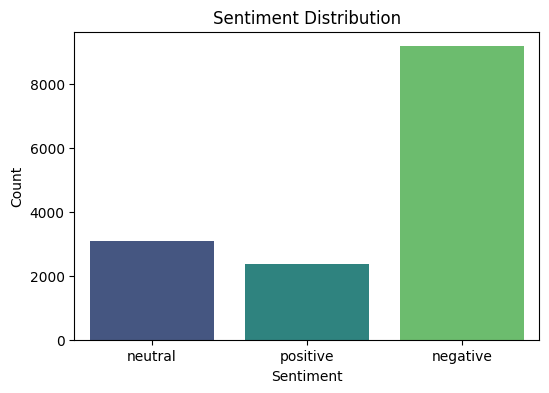

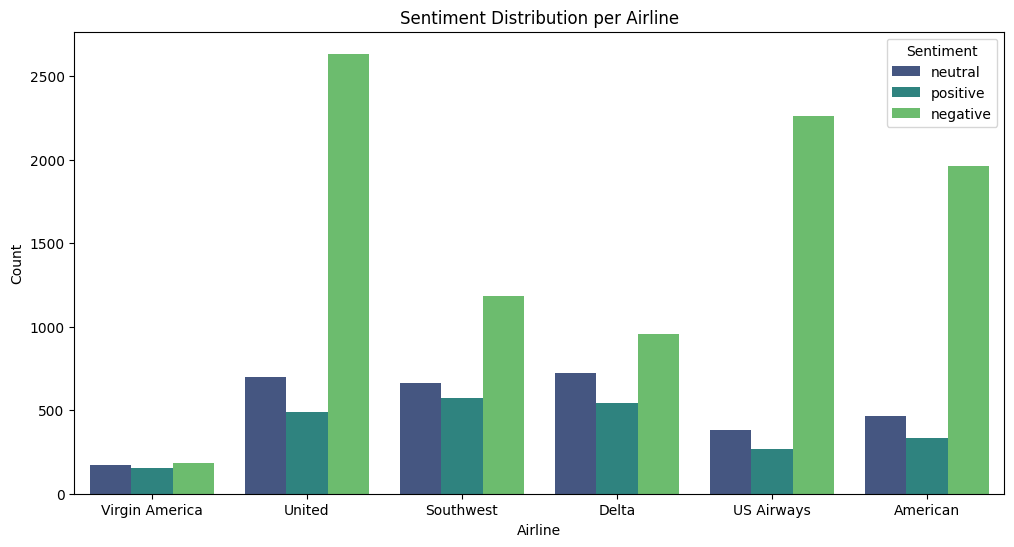

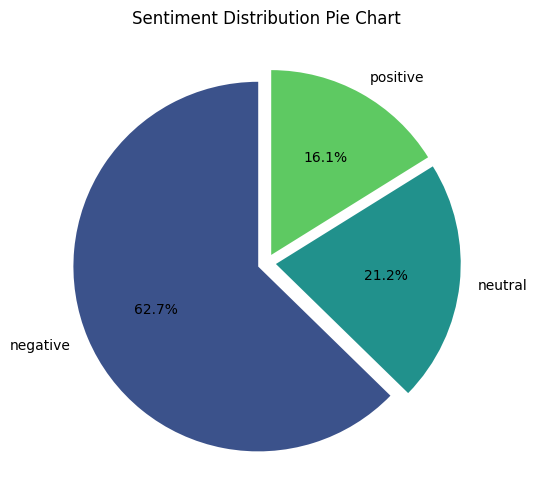

In [ ]:
# Check the shape of the dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Distribution of sentiments
plt.figure(figsize=(6,4))
sns.countplot(x='airline_sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Distribution of sentiments per airline
plt.figure(figsize=(12,6))
sns.countplot(x='airline', hue='airline_sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution per Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Pie chart for sentiment distribution
plt.figure(figsize=(6,6))
df['airline_sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('viridis', 3), startangle=90, explode=[0.05]*3)
plt.title('Sentiment Distribution Pie Chart')
plt.ylabel('')  # To remove the y-label
plt.show()

In [ ]:
def preprocess_text(text):
    # Check if text is a string
    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#','', text)

    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)

    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

# Display cleaned text
df[['text', 'clean_text']].head()

text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                          clean_text  
0                                          what said  
1  plus you ve added commercials to the experienc...  
2     didn today must mean need to take another trip  
3  it really aggressive to blast obnoxious entert...  
4             and it a really big bad thing about it

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define features and labels
X = df['clean_text']
y = df['airline_sentiment'].map({'negative':0, 'neutral':1, 'positive':2})  # Encoding sentiments

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform the data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

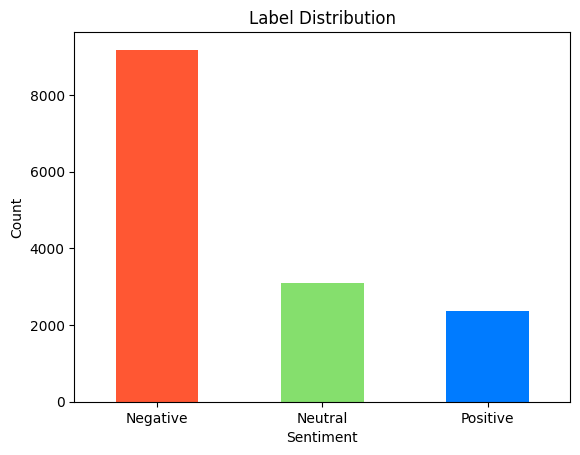

In [ ]:
# Encode sentiments
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(label_mapping)

# Display label distribution with custom colors
colors = ['#FF5733', '#85df6d', '#007BFF']  # Example colors: red, light green, and blue

df['label'].value_counts().sort_index().plot(kind='bar', color=colors)
plt.title('Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'], rotation=0)
plt.show()

In [ ]:
# Define features and labels
X = df['clean_text']
y = df['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 11712
Testing set size: 2928


In [ ]:
from transformers import BertTokenizer

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=128
    )

# Tokenize training and testing data
train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset

class TweetsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create dataset objects
train_dataset = TweetsDataset(train_encodings, y_train.tolist())
test_dataset = TweetsDataset(test_encodings, y_test.tolist())

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Initialize the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,  # Negative, Neutral, Positive
    output_attentions=False,
    output_hidden_states=False
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,              # Number of training epochs
    per_device_train_batch_size=64,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to="none",
)

# Define a metric computation function
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train the model
trainer.train()

TrainOutput(global_step=1098, training_loss=0.3069882990286867, metrics={'train_runtime': 574.8446, 'train_samples_per_second': 122.245, 'train_steps_per_second': 1.91, 'total_flos': 1444492663326720.0, 'train_loss': 0.3069882990286867, 'epoch': 6.0})

In [ ]:
# Evaluate the model
trainer.evaluate()

{'eval_loss': 0.45185863971710205,
 'eval_accuracy': 0.8346994535519126,
 'eval_f1': 0.8349603457086665,
 'eval_precision': 0.8352771332194517,
 'eval_recall': 0.8346994535519126,
 'eval_runtime': 7.1974,
 'eval_samples_per_second': 406.815,
 'eval_steps_per_second': 6.391,
 'epoch': 6.0}

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      1835
     Neutral       0.69      0.70      0.69       620
    Positive       0.78      0.76      0.77       473

    accuracy                           0.83      2928
   macro avg       0.79      0.79      0.79      2928
weighted avg       0.84      0.83      0.83      2928



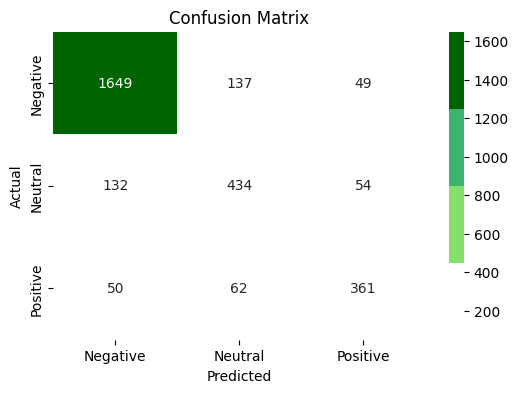

Accuracy: 83.47%


In [ ]:
import matplotlib.colors as mcolors

# Predictions
predictions, true_labels, _ = trainer.predict(test_dataset)
preds = np.argmax(predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, preds, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))

# Create a custom colormap
cmap = mcolors.ListedColormap(['#ffffff', '#85df6d', '#3cb371', '#006400'])  # White to light green to dark green

sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Explainable AI

In [ ]:
from lime.lime_text import LimeTextExplainer

# Define class names
class_names = ['Negative', 'Neutral', 'Positive']

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
def predict_proba(texts):
    # Tokenize the texts
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    # Move tensors to the same device as the model
    encodings = {key: val.to(model.device) for key, val in encodings.items()}

    # Get logits from the model
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs

In [ ]:
# Select a sample from the test set
sample_idx = 42
sample_text = X_test.iloc[sample_idx]
actual_sentiment = y_test.iloc[sample_idx]
predicted_sentiment = preds[sample_idx]

print(f"Original Tweet: {df.iloc[X_test.index[sample_idx]]['text']}")
print(f"Cleaned Tweet: {sample_text}")
print(f"Actual Sentiment: {class_names[actual_sentiment]}")
print(f"Predicted Sentiment: {class_names[predicted_sentiment]}")

# Generate explanation
exp = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10,
    labels=[predicted_sentiment]
)

# Display the explanation
exp.show_in_notebook(text=True)

Original Tweet: @JetBlue Do you have any flights with lie flat seating from STL to PDX on or around the date of March 5?
Cleaned Tweet: do you have any flights with lie flat seating from stl to pdx on or around the date of march
Actual Sentiment: Neutral
Predicted Sentiment: Neutral


In [ ]:
# Function to display explanations for multiple samples
def display_lime_explanations(texts, labels, preds, num_samples=3):
    for i in range(num_samples):
        idx = np.random.randint(0, len(texts))
        text = texts.iloc[idx]
        actual = labels.iloc[idx]
        pred = preds[idx]
        print(f"\nSample {i+1}")
        print(f"Original Tweet: {df.iloc[X_test.index[idx]]['text']}")
        print(f"Cleaned Tweet: {text}")
        print(f"Actual Sentiment: {class_names[actual]}")
        print(f"Predicted Sentiment: {class_names[pred]}")
        exp = explainer.explain_instance(
            text,
            predict_proba,
            num_features=10,
            labels=[pred]
        )
        exp.show_in_notebook(text=True)

# Display explanations for 3 random samples
display_lime_explanations(X_test, y_test, preds, num_samples=3)


Sample 1
Original Tweet: @AmericanAir don't see response!
Cleaned Tweet: don see response
Actual Sentiment: Negative
Predicted Sentiment: Negative



Sample 2
Original Tweet: @JetBlue  thanks for response! Crew has been VERY patient with us, but they are also frustrated. Wouldn't be so bad but airport is closed!
Cleaned Tweet: thanks for response crew has been very patient with us but they are also frustrated wouldn be so bad but airport is closed
Actual Sentiment: Negative
Predicted Sentiment: Positive



Sample 3
Original Tweet: @USAirways now on hold for 90 minutes
Cleaned Tweet: now on hold for minutes
Actual Sentiment: Negative
Predicted Sentiment: Negative
